# Forecasting
This Notebook reads pre-processed predictor (SWE) and predictand (discharge volumes) data. It then further processes the predictor into principal components using a Principal Component Analysis (PCA). It then uses the principal components as inputs to an Ordinary Least Squares (OLS) regression model to produce ensemble hindcasts (retrospective forecasts) of the predictand. Note that in this workflow we might use the terms forecast and hindcast interchangeably as they would be generated the same way with this method, but either for the future or in hindsight, respectively.

Decisions:
- We use SWE data on the 1st of each month only for forecasting.
- As a result of the PCA design, we assume that we will use all PCs monthly data independently from other months for the forecasting. This is to ensure that we maximize the amount of data we can use each month. E.g., 1st April has more data than 1st November and we would have to drop all the additional data in April if we were to unify the PCA across months, as PCA does not allow for any missing data.
- We use the first SWE principal component only as a predictor for forecasting (see user-specified variables below). If using more PCs, we should be careful with overfitting when the dataset has a few years compared to the number of PCs.
- We use a leave-one-out strategy for cross-validation of the model (see user-specified variables below).
- We use an OLS regression model. This could be replaced with other models in the future.
- We generate ensemble hindcasts with 100 ensemble members (see user-specified variables below).
- The ensemble members are generated with an even distribution (vs. random; see user-specified variables below).

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at input data stationarity.
- We are keeping all data available to build the models, but we could decide to discard extreme years for training the forecast model, as including them could skew the results.

## Modules, settings & functions

In [497]:
# Import required modules
import datetime
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
from pprint import pprint
import rasterio
from rasterio.plot import show
from sklearn.metrics import mean_squared_error
import sys
import xarray as xr

In [498]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2025-01-21 16:28:21,838 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE_PREVAH\logs\data_driven_forecasting_20250121_162821.log


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [499]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 4_Forecasting')

In [500]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2025-01-21 16:28:23,463 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../PREVAH/input_data/SWE_prevah_m3.nc',
 'basins_dem_path': '../PREVAH/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../PREVAH/input_data/ebene_40km_with_ids.shp',
 'domain': 'V947',
 'glacier_component_path': '../PREVAH/input_data/GL_prevah.nc',
 'output_data_path': '../PREVAH/output_data_glaciated/',
 'plots_path': '../PREVAH/output_plots_glaciated/',
 'precip_obs_path': '../PREVAH/input_data/P_prevah_m3.nc',
 'streamflow_obs_path': '../PREVAH/input_data/Q_prevah_m3.nc'}


In [501]:
# Import required functions
from functions import deterministic_forecasting, ensemble_dressing, ensemble_forecasting, leave_out, OLS_model_fitting, principal_component_analysis

## Variables

In [864]:
# Set user-specified variables
#test_basin_id = 'V457'  # Set basin_id for testing
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
PC_no_default, PC_id_default = 1, 'PC1'  # integer > 0 for the number of principal components of SWE to use for the forecasting, and string of the PC to use (if PC_no > 1, PC_id should be a list of strings)
target_periods = ['01/01-30/09','01/02-30/09','01/03-30/09','01/04-30/09','01/05-30/09','01/06-30/09','01/07-30/09','01/08-30/09','01/09-30/09']  # target periods for predictand, where each period is described as 'start_DD/start_MM-end_DD/end_MM'
init_dates = ['01/01','01/02','01/03','01/04','01/05','01/06','01/07','01/08','01/09'] # initialization dates for predictor, where each date is described as 'DD/MM'
min_obs_corr_default = 3 # minimum number of observations required to calculate the correlation between predictand-predictor
min_years_overlap_default = 10 # minimum number of years required of predictor-predictand to be able to generate a forecast
nyears_leaveout_default = 1 # number of years to leave out at a time for forecast cross-validation
method_traintest_default = 'leave_out' # method to use for the cross-validation - no other methods are implemented at this stage
ens_size_default = 100  # number of forecast ensemble members to generate
test_target_period = '01/09-30/09'  # target period used for the workflow step-by-step demonstration
test_init_date = '01/09' # initialization date used for the workflow step-by-step demonstration

In [865]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'PCs used as predictors for forecasting: {PC_id_default}')
logger.debug(f'forecast target periods: {target_periods}')
logger.debug(f'forecast initialization dates: {init_dates}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of predictor-predictand for forecast generation: {min_years_overlap_default}')
logger.debug(f'number of years left out at a time for cross-validation: {nyears_leaveout_default}')
logger.debug(f'forecast ensemble size: {ens_size_default}')

## Read data

In [866]:
# Read pre-processed predictand data & format to Pandas DataFrame for forecasting
predictand_ds = xr.open_dataset(settings['output_data_path']+"Vol_1979_2021_basin"+test_basin_id+".nc")
predictand_da = predictand_ds.sel(Station_ID=test_basin_id)
predictand_df = predictand_da.to_dataframe().reset_index().drop(columns=['lat','lon','Station_ID']).set_index('year')

display(predictand_df.head())

,area,Vol_1Jan-30Sep,Vol_1Feb-30Sep,Vol_1Mar-30Sep,Vol_1Apr-30Sep,Vol_1May-30Sep,Vol_1Jun-30Sep,Vol_1Jul-30Sep,Vol_1Aug-30Sep,Vol_1Sep-30Sep
year,,,,,,,,,,
1981,1.125907e+08,8.162041e+07,8.078217e+07,8.032415e+07,7.710608e+07,6.815253e+07,5.864537e+07,3.533008e+07,1.796532e+07,6.743735e+06
1982,1.125907e+08,9.538001e+07,9.403208e+07,9.326162e+07,9.246188e+07,9.064861e+07,7.598851e+07,4.427811e+07,2.295646e+07,8.633346e+06
1983,1.125907e+08,7.919948e+07,7.792338e+07,7.714301e+07,7.594257e+07,7.322283e+07,6.551093e+07,4.028677e+07,1.513614e+07,7.322339e+06
1984,1.125907e+08,6.943978e+07,6.828381e+07,6.746156e+07,6.694218e+07,6.521110e+07,6.064802e+07,4.126563e+07,1.746159e+07,7.312431e+06
1985,1.125907e+08,7.060318e+07,6.979906e+07,6.911045e+07,6.838199e+07,6.636290e+07,5.658439e+07,3.702502e+07,1.630460e+07,6.225480e+06


Note: We're only showing the first few rows of data, otherwise it takes too much space. Same for the predictors below.

In [867]:
# Read pre-processed predictor data for basin of interest & format to Pandas DataFrame for forecasting
predictor_ds = xr.open_dataset(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc")
display(predictor_ds)
try:
    predictor_df = predictor_ds.to_dataframe().drop(columns=['flag','donor_stations','lat','lon']).unstack(level='station_id')
except KeyError:
    predictor_ds['Station_ID'] = predictor_ds['Station_ID'].astype(str)
    predictor_df = predictor_ds.to_dataframe().drop(columns=['lat','lon', 'area']).unstack(level='Station_ID')
    
predictor_df.columns = predictor_df.columns.droplevel()
display(predictor_ds)
display(predictor_df.head())

<xarray.Dataset>
Dimensions:     (Station_ID: 1, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V947'
    lon         (Station_ID) float64 ...
    lat         (Station_ID) float64 ...
    area        (Station_ID) float64 ...
Data variables:
    swe         (time, Station_ID) float64 ...

<xarray.Dataset>
Dimensions:     (Station_ID: 1, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) <U4 'V947'
    lon         (Station_ID) float64 2.621e+06
    lat         (Station_ID) float64 1.118e+06
    area        (Station_ID) float64 1.126e+08
Data variables:
    swe         (time, Station_ID) float64 545.1 554.2 588.7 ... 180.4 178.1

Station_ID,V947
time,
1981-01-01,545.129465
1981-01-02,554.171909
1981-01-03,588.676281
1981-01-04,612.141809
1981-01-05,619.750806


In [868]:
# Diese zelle obere neu von LNU für camels SWE daten
#predictor_ds = xr.open_dataset(settings['output_data_path']+"SWE_Camels_"+test_basin_id+".nc")
#predictor_df = predictor_ds.to_dataframe().drop(columns=['lat','lon','station_name']).unstack(level='station_id')
#predictor_df.columns = predictor_df.columns.droplevel()

#display(predictor_df.head())
#display(predictor_df)

## Hindcast generation

### Workflow step-by-step demonstration
Let's go over the forecasting steps for a test forecast start date and target period to see how it works.

In [869]:
# Define initialization date for which to produce hindcasts
init_day, init_month = int(test_init_date[0:2]), int(test_init_date[3:5])
init_month_name = datetime.datetime.strptime(str(init_month), "%m").strftime("%b")
    
# Define target period for which to produce hindcasts
target_start_day, target_start_month = int(test_target_period[0:2]), int(test_target_period[3:5])
target_end_day, target_end_month = int(test_target_period[6:8]), int(test_target_period[9:11])
target_start_month_name = datetime.datetime.strptime(str(target_start_month), "%m").strftime("%b")
target_end_month_name = datetime.datetime.strptime(str(target_end_month), "%m").strftime("%b")

print("We will generate hindcasts initialized on",init_day, init_month_name, "for the target period", target_start_day, target_start_month_name,"-",target_end_day,target_end_month_name,".")

We will generate hindcasts initialized on 1 Sep for the target period 1 Sep - 30 Sep .


In [870]:
# Select predictor of interest
predictor_subset_df = predictor_df[(predictor_df.index.month == init_month) & (predictor_df.index.day == init_day)]

display(predictor_subset_df.head())

Station_ID,V947
time,
1981-09-01,459.720784
1982-09-01,439.764596
1983-09-01,382.712102
1984-09-01,441.462579
1985-09-01,448.926928


Note: Again here we're only showing the first few rows of data, otherwise it takes too much space. Same for the predictand below.

In [871]:
# Select predictand of interest
predictand_subset_df = predictand_df['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

display(predictand_subset_df.head())

year
1981    6.743735e+06
1982    8.633346e+06
1983    7.322339e+06
1984    7.312431e+06
1985    6.225480e+06
Name: Vol_1Sep-30Sep, dtype: float64

In [872]:
# Clean predictor and predictand datasets and find the number of overlapping years with data
cleaned_predictor_data = predictor_subset_df.dropna(axis=1,thresh=min_years_overlap_default).dropna(axis=0,how='any')
cleaned_predictand_data = predictand_subset_df.dropna()

if (cleaned_predictor_data.empty == False) and (cleaned_predictand_data.empty == False):
    cleaned_predictor_data_years = cleaned_predictor_data.index.year.values
    cleaned_predictand_data_years = cleaned_predictand_data.index.values
    overlapping_years = list(set(cleaned_predictor_data_years) & set(cleaned_predictand_data_years))
    overlapping_years.sort()
else:
    overlapping_years = []
    
overlapping_predictor_data = cleaned_predictor_data[cleaned_predictor_data.index.year.isin(overlapping_years)]
overlapping_predictand_data = predictand_subset_df.loc[overlapping_years]
    
print("There are",str(len(overlapping_years)),"overlapping years with data between the predictors and the predictand for this starting date-target period combination.")
display(overlapping_predictor_data)
display(overlapping_predictand_data)

There are 42 overlapping years with data between the predictors and the predictand for this starting date-target period combination.


Station_ID,V947
time,
1981-09-01,459.720784
1982-09-01,439.764596
1983-09-01,382.712102
1984-09-01,441.462579
1985-09-01,448.926928
1986-09-01,422.644026
1987-09-01,433.546042
1988-09-01,411.671641
1989-09-01,415.350387


year
1981    6.743735e+06
1982    8.633346e+06
1983    7.322339e+06
1984    7.312431e+06
1985    6.225480e+06
1986    4.417948e+06
1987    6.788884e+06
1988    4.208304e+06
1989    3.996634e+06
1990    5.486772e+06
1991    5.032469e+06
1992    5.595084e+06
1993    7.172030e+06
1994    1.014195e+07
1995    7.464541e+06
1996    3.742404e+06
1997    7.665065e+06
1998    6.095663e+06
1999    6.390426e+06
2000    5.671759e+06
2001    5.085837e+06
2002    7.982459e+06
2003    4.785895e+06
2004    6.050176e+06
2005    5.321151e+06
2006    6.114578e+06
2007    5.327344e+06
2008    7.524890e+06
2009    3.740715e+06
2010    4.107423e+06
2011    4.162818e+06
2012    3.431541e+06
2013    3.483220e+06
2014    3.202081e+06
2015    3.778433e+06
2016    1.769251e+06
2017    2.608502e+06
2018   -1.022887e+06
2019   -9.263967e+05
2020   -4.504756e+05
2021    6.264549e+05
2022   -9.217804e+05
Name: Vol_1Sep-30Sep, dtype: float64

We need a minimum number of years of data to be able to produce reliable hindcasts. min_years_overlap_default defines the minimum number of years requires. If this condition is met, we can proceed with the forecasting steps below.

We now run a Principal Component Analysis (PCA), a statistical method used to transform a set of intercorrelated variables into an equal number of uncorrelated variables. This step becomes particularly essential after gap filling, which might have introduced additional correlation across the SWE stations.

<IPython.core.display.Javascript object>


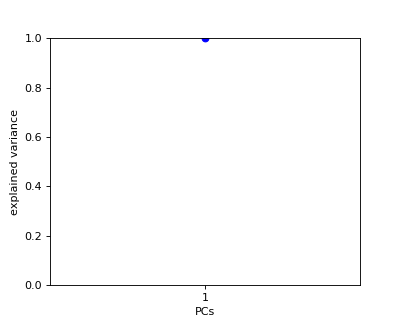

In [873]:
# Run PCA

PCs, loadings, fig = principal_component_analysis(overlapping_predictor_data, flag=1)

This plot shows the variance in the predictor data (gap-filled SWE stations observations) captured by each principal component. Where the captured variance decreases with each new PC. For the Bow at Banff, we can see that the first principal component captures more than 90% of the variance. We will therefore use PC1 as the sole predictor for the rest of the forecasting process. (LNU: ein hoher PC1 bedeuted wahrscheindlich dass die Stationen untereinander sehr stark korrelieren.)

<IPython.core.display.Javascript object>


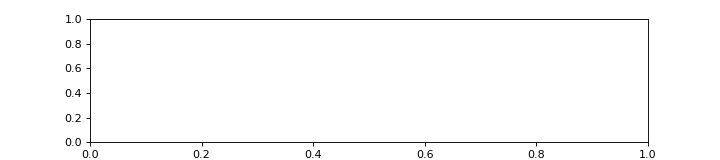

TypeError: 'AxesSubplot' object is not subscriptable

In [874]:
# Plot PC1 vs. each stations' SWE
if len(overlapping_predictor_data.columns) < 5:
    fig, ax = plt.subplots(1,len(overlapping_predictor_data.columns), figsize=[9,2])
    col = -1
    for s in range(len(overlapping_predictor_data.columns)):
        col += 1
        ax[col].scatter(overlapping_predictor_data.iloc[:,s], PCs['PC1'], color='b', alpha=.3) 
        ax[col].tick_params(axis='x', labelsize=8)
        ax[col].tick_params(axis='y', labelsize=8)
        ax[col].set_xlabel(overlapping_predictor_data.columns[s], fontweight='bold')
    ax[0].set_ylabel('PC1', fontweight='bold')
    plt.tight_layout();
    
elif len(overlapping_predictor_data.columns) > 4:
    nrow = int(len(overlapping_predictor_data.columns)/4)
    ncol = 4
    if len(overlapping_predictor_data.columns)%4 != 0:
        nrow += 1
    fig, ax = plt.subplots(nrow,ncol, figsize=[9,2*nrow])
    row = 0
    col = -1
    for s in range(len(overlapping_predictor_data.columns)):
        col += 1
        if col == ncol:
            row += 1
            col = 0
        ax[row,col].scatter(overlapping_predictor_data.iloc[:,s], PCs['PC1'], color='b', alpha=.3) 
        ax[row,col].tick_params(axis='x', labelsize=8)
        ax[row,col].tick_params(axis='y', labelsize=8)
        ax[row,col].set_xlabel(overlapping_predictor_data.columns[s], fontweight='bold')
    for r in range(nrow):
        ax[r,0].set_ylabel('PC1', fontweight='bold')
    empties = 4*nrow - len(overlapping_predictor_data.columns)
    for c in range(ncol-empties, ncol):
        fig.delaxes(ax[nrow-1,c]);
    plt.tight_layout();

This plot shows how well PC1 correlates with each individual station observations. Note than the correlations can be negative due to the SWE observations being standardized prior to the PCA. This however should not impact the next forecasting steps. Let's have a look at the spatial patterns in these correlations now. (LNU:x-axis corresponding to the SWE values at that station, and the y-axis showing the corresponding value of PC1 for each year. If they are along diagonal and tightly clustered meaning SWE has a strong correlation with PC1. In PCA, each station (variable) contributes to the principal components, but those that show more variance aligned with the main trends (like 44138) will have a higher contribution to PC1.)

In [875]:
# Make map of PCA loadings (correlation between stations & PCs data)
# Note that this takes a few seconds to plot as it needs to load the DEM

# Load DEM
src = rasterio.open(settings['basins_dem_path']+test_basin_id+".tif")

# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.Station_ID == test_basin_id]

# Add basin contour & elevation shading to map
shp_testbasin_gdf.plot(edgecolor='k', facecolor='none', lw=.5)
rasterio.plot.show((src, 1), cmap='Greys', vmin=0, alpha=.7)

# Extract geospatial information for stations to plot
SWE_stations_geos = predictor_ds.sel(station_id=loadings.columns)

# plot data
#sc = plt.scatter(SWE_stations_geos.lon.values, SWE_stations_geos.lat.values, c=loadings.loc['PC1'].values, cmap='rocket_r')
sc = plt.scatter(SWE_stations_geos.lon.values, SWE_stations_geos.lat.values, c=loadings.loc['PC1'].values, cmap='viridis')

# Remove frame ticks
plt.xticks([])
plt.yticks([])

# Add colorbar
cbar = plt.colorbar(sc, fraction=.03)
cbar.set_label('R$^2$');

RasterioIOError: ../PREVAH/input_data/MERIT_Hydro_dem_V947.tif: No such file or directory

We can see some spatial patterns in the signal picked up by PC1 across the river basin. We now plot a timeseries of all PCs and of the predictand to see what the temporal patterns are.

<IPython.core.display.Javascript object>


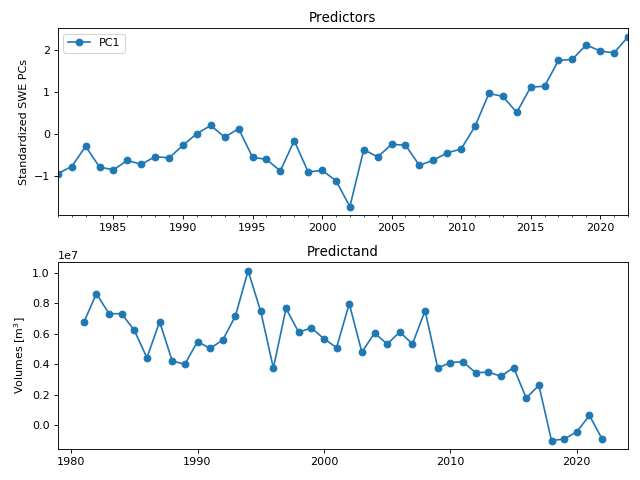

In [876]:
# Plot all PCs and the predictand
fig, ax = plt.subplots(2, 1, figsize=(8,6))
for pc in range(len(PCs.columns)):
    PCs.iloc[:,pc].plot(ax=ax[0], marker='o', label=PCs.iloc[:,pc].name)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Standardized SWE PCs')
ax[0].legend()
ax[0].set_title('Predictors')
overlapping_predictand_data.plot(ax=ax[1], marker='o')
ax[1].set_xlabel('')
ax[1].set_ylabel('Volumes [m$^3$]')
ax[1].set_title('Predictand')
plt.tight_layout();

This plot helps us understand check visually whether the PCs and the predictand follow a similar temporal behavior visually. We can see for the Bow River at Banff how PC1 has a clear signal that fluctuates over time, while the other PCs seem to have smaller values that are more noisy.

In [877]:
# Combine the PCs and the predictand into a single DataFrame for forecasting
combined_df = PCs.reset_index(drop=True)
combined_df['year'] = overlapping_years
combined_df = combined_df.set_index('year')
combined_df['Vol'] = overlapping_predictand_data

display(combined_df.head())

,PC1,Vol
year,,
1981,-0.946393,6.743735e+06
1982,-0.778353,8.633346e+06
1983,-0.297945,7.322339e+06
1984,-0.792650,7.312431e+06
1985,-0.855504,6.225480e+06


We will now go over the model building and ensemble dressing steps in cross-validation mode. We will only print out the outputs for the last year left out and predicted for illustrative purposes.

In [878]:
# Split the timeseries into training and validation timeseries for forecasting
train_data_dict, test_data_dict = leave_out(combined_df, nyears_leaveout_default)

# Loop over the samples
for s in list(train_data_dict.keys()):

    # Select train and test data
    train_data = train_data_dict[s]
    test_data = test_data_dict[s]

    # Fit the model on the training data
    OLS_model = OLS_model_fitting(PC_id_default, train_data)

    # Perform out-of-sample deterministic forecasting for the testing period
    fc_det = deterministic_forecasting(OLS_model, test_data)

    # Calculate errors standard deviation for the training period
    fc_det_train = deterministic_forecasting(OLS_model, train_data)
    rmse = mean_squared_error(train_data['Vol'].values, fc_det_train['Vol_fc_mean'].values, squared=False)

    # generate ensembles
    fc_ens = ensemble_dressing(fc_det, rmse, ens_size=ens_size_default)

    # append all ensembles generated for each moving window
    if s == 0:
        fc_ens_df = fc_ens
    else:
        fc_ens_df = pd.concat([fc_ens_df,fc_ens])

In [879]:
# Print a summary of the model
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Vol   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     63.42
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           1.06e-09
Time:                        16:55:34   Log-Likelihood:                -641.92
No. Observations:                  41   AIC:                             1288.
Df Residuals:                      39   BIC:                             1291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.83e+06   2.45e+05     19.743      0.0

For a breakfown of what the regression results mean, see this [post](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a).

In [880]:
# Plot the predictor, predictand & the errors standard deviation for the training period
"""
sorted_data = fc_det_train.sort_values(by='Vol_fc_mean')
sorted_data = fc_det_train.sort_values(by='Vol_fc_mean').reindex(train_data.index)
plt.scatter(train_data[PC_id_default], train_data['Vol'], color='r', label='observations')
plt.plot(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean'], color='b', label='regression line')
plt.fill_between(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean']+rmse, sorted_data['Vol_fc_mean']-rmse, color='purple', alpha=.1, label='errors SD')
plt.xlabel('Standardized SWE PC1')
plt.ylabel('Volume [m$^3$]')
plt.legend();


print(train_data[PC_id_default].head())
print(sorted_data['Vol_fc_mean'].head())
print(rmse)
print(train_data[PC_id_default].index)
print(sorted_data.index)
"""

"\nsorted_data = fc_det_train.sort_values(by='Vol_fc_mean')\nsorted_data = fc_det_train.sort_values(by='Vol_fc_mean').reindex(train_data.index)\nplt.scatter(train_data[PC_id_default], train_data['Vol'], color='r', label='observations')\nplt.plot(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean'], color='b', label='regression line')\nplt.fill_between(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean']+rmse, sorted_data['Vol_fc_mean']-rmse, color='purple', alpha=.1, label='errors SD')\nplt.xlabel('Standardized SWE PC1')\nplt.ylabel('Volume [m$^3$]')\nplt.legend();\n\n\nprint(train_data[PC_id_default].head())\nprint(sorted_data['Vol_fc_mean'].head())\nprint(rmse)\nprint(train_data[PC_id_default].index)\nprint(sorted_data.index)\n"

year
2019    2.119157
2020    1.970934
2021    1.929818
2018    1.775494
2017    1.746778
Name: PC1, dtype: float64
year
2019    4.635445e+05
2020    7.689806e+05
2021    8.537059e+05
2018    1.171714e+06
2017    1.230888e+06
Name: Vol_fc_mean, dtype: float64


<IPython.core.display.Javascript object>


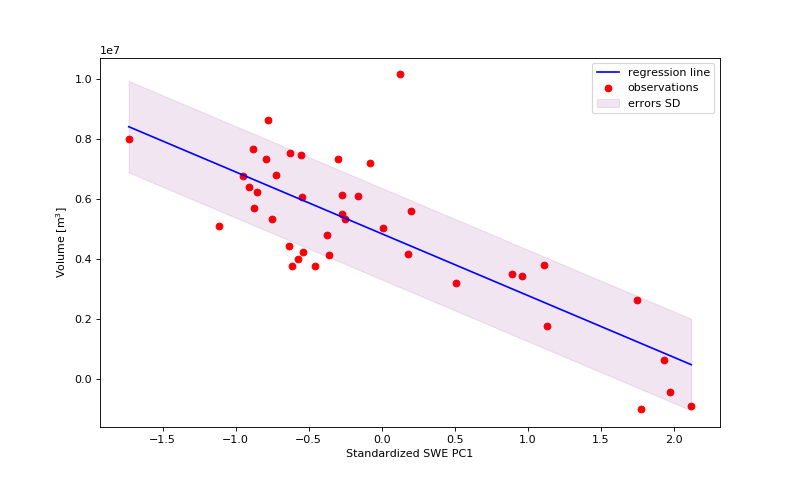

In [881]:
# plot von oben code angepasst damit es funktioniert 
#Sortiere nach 'Vol_fc_mean' und stelle sicher, dass Indizes übereinstimmen
sorted_data = fc_det_train.sort_values(by='Vol_fc_mean')

# Überprüfen der relevanten Daten (falls nötig, diese Zeilen auskommentieren)
print(train_data[PC_id_default].loc[sorted_data.index].head())
print(sorted_data['Vol_fc_mean'].head())

# Erstellen des Plots
plt.figure(figsize=(10, 6))

# Streudiagramm der Beobachtungen
plt.scatter(train_data[PC_id_default], train_data['Vol'], color='r', label='observations')

# Regressionslinie plotten
plt.plot(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean'], color='b', label='regression line')

# Füllung für Standardabweichung der Fehler (rmse)
plt.fill_between(train_data[PC_id_default].loc[sorted_data.index], 
                 sorted_data['Vol_fc_mean'] + rmse, 
                 sorted_data['Vol_fc_mean'] - rmse, 
                 color='purple', alpha=.1, label='errors SD')

# Achsenbeschriftungen
plt.xlabel('Standardized SWE PC1')
plt.ylabel('Volume [m$^3$]')
plt.legend()

# Zeige den Plot an
plt.show()


The shaded area shows the Standard Deviation (SD) of the errors between the observations and the regression line. This is used to generate ensembles around the deterministic forecast for the year left out, by drawing random samples from a normal (Gaussian) distribution within this space.

<IPython.core.display.Javascript object>


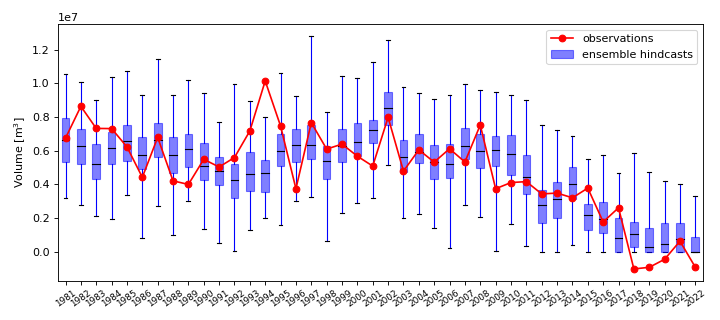

In [882]:
# Plot timeseries of ensemble hindcasts and observations
fig = plt.figure(figsize=(9,4))
ts_ax = plt.subplot()
obs, = ts_ax.plot(np.arange(1, len(overlapping_predictand_data.index)+1), overlapping_predictand_data.values, color='red', label='observations', marker='o')
bp = plt.boxplot(np.transpose(fc_ens_df.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
plt.setp(bp['boxes'], color='b', alpha=.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')
bluepatch = mpatches.Patch(color='b', alpha=.5, label='ensemble hindcasts')
ts_ax.set_ylabel('Volume [m$^3$]')
ts_ax.set_xticks(np.arange(1, len(overlapping_predictand_data.index)+1))
ts_ax.set_xticklabels(overlapping_predictand_data.index.values, rotation=35, fontsize=8)
plt.legend(handles=[obs,bluepatch])
plt.tight_layout();

### Generate all hindcasts
We now generate hindcasts for all combinations of forecast initialization dates and target periods.

In [883]:
# Ensemble forecasting

counter = 0

for i in init_dates:

    for p in target_periods:

        # Define initialization date for which to produce hindcasts
        init_day, init_month = int(i[0:2]), int(i[3:5])

        # Define target period for which to produce hindcasts
        target_start_day, target_start_month = int(p[0:2]), int(p[3:5])
        target_end_day, target_end_month = int(p[6:8]), int(p[9:11])
        target_start_month_name = datetime.datetime.strptime(str(target_start_month), "%m").strftime("%b")
        target_end_month_name = datetime.datetime.strptime(str(target_end_month), "%m").strftime("%b")

        # Check that the target period starts after the initialization date so we can proceed with the hindcasting
        # Note: We assume that the initialization date and target period are both in the same year. No cross-year forecasting
        if (target_start_month > init_month) or ((target_start_month == init_month) & (target_start_day >= init_day)):

            counter += 1
            
            # Select predictor of interest
            predictor_subset_df = predictor_df[(predictor_df.index.month == init_month) & (predictor_df.index.day == init_day)]

            # Select predictand of interest
            predictand_subset_df = predictand_df['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

            # Generate ensemble hindcasts
            ens_hindcasts_df = ensemble_forecasting(predictor_subset_df, predictand_subset_df, PC_ids=PC_id_default, ens_size=ens_size_default, min_overlap_years=min_years_overlap_default, method_traintest=method_traintest_default, nyears_leaveout=nyears_leaveout_default)

            # Save ensemble hindcasts to xarray DataArray
            if ens_hindcasts_df is not None:
                switch = 1
                ens_hindcasts_da = xr.DataArray(data=ens_hindcasts_df.to_numpy().reshape((ens_hindcasts_df.to_numpy().shape[0], ens_hindcasts_df.to_numpy().shape[1], 1)), coords={'year':ens_hindcasts_df.index,'ens_member':ens_hindcasts_df.columns,'init_date':[i]}, dims=['year','ens_member','init_date'], name='Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name)
            else:
                ens_hindcasts_da = xr.DataArray(data=np.reshape([np.nan]*ens_size_default,(1,ens_size_default,1)), coords={'year':[2000],'ens_member':np.arange(1,ens_size_default+1),'init_date':[i]}, dims=['year','ens_member','init_date'], name='Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name)
            ens_hindcasts_da.attrs['long_name'] = 'Ensemble volume hindcasts'
            ens_hindcasts_da.attrs['info'] = 'Ensemble hindcasts of '+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name+' volumes in basin '+test_basin_id+'. The hindcasts are generated using an Ordinary Least Squares (OLS) regression model, intialized with principal components ('+PC_id_default+') of gap filled SWE station observations on init_date as predictors.'
            ens_hindcasts_da.attrs['units'] = 'm3'

            # Save ensemble hindcasts to xarray Dataset
            if counter == 1:
                ens_hindcasts_ds = ens_hindcasts_da
            else:
                ens_hindcasts_ds = xr.merge([ens_hindcasts_ds, ens_hindcasts_da])

    # Add information to the Dataset
    ens_hindcasts_ds.init_date.attrs['long_name'] = 'Hindcast initialization date'
    ens_hindcasts_ds.init_date.attrs['info'] = 'DD/MM of the predictors used to generate the hindcasts.'
    ens_hindcasts_ds.ens_member.attrs['long_name'] = 'Ensemble member'
    
display(ens_hindcasts_ds)

<xarray.Dataset>
Dimensions:         (ens_member: 100, init_date: 9, year: 42)
Coordinates:
  * init_date       (init_date) object '01/01' '01/02' ... '01/08' '01/09'
  * year            (year) int64 1981 1982 1983 1984 ... 2019 2020 2021 2022
  * ens_member      (ens_member) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
Data variables:
    Vol_1Jan-30Sep  (year, ens_member, init_date) float64 7.054e+07 nan ... nan
    Vol_1Feb-30Sep  (year, ens_member, init_date) float64 6.558e+07 ... nan
    Vol_1Mar-30Sep  (year, ens_member, init_date) float64 6.464e+07 ... nan
    Vol_1Apr-30Sep  (year, ens_member, init_date) float64 7.063e+07 ... nan
    Vol_1May-30Sep  (year, ens_member, init_date) float64 6.63e+07 ... nan
    Vol_1Jun-30Sep  (year, ens_member, init_date) float64 3.333e+07 ... nan
    Vol_1Jul-30Sep  (year, ens_member, init_date) float64 4.758e+07 ... nan
    Vol_1Aug-30Sep  (year, ens_member, init_date) float64 1.583e+07 ... nan
    Vol_1Sep-30Sep  (year, ens_member, init_date) float64 7.14e+06 ... 1.183e+06

## Save data
Save the output hindcasts so we can read them in other Notebooks.

In [884]:
# Save the data
ens_hindcasts_ds.to_netcdf(settings['output_data_path']+'ensemble_hindcasts_basin'+test_basin_id+'.nc', format="NETCDF4")

We can optionally store each model used to generate these hindcasts using the following code: model_fit.save('OLS_model.pkl', remove_data=False)
To load model back we would do: loaded = sm.load('OLS_model.pkl')
Note that a unique model is built for each initialization date - target period combination, but also for each year left out.

# Glacier part

In [885]:
#read glacier data
GL_component_ds = xr.open_dataset(settings['glacier_component_path'])
GL_component_testbasin_da = GL_component_ds.where(GL_component_ds.Station_ID==test_basin_id, drop=True).gl_tot
display(GL_component_testbasin_da)

<xarray.DataArray 'gl_tot' (time: 15340, Station_ID: 1)>
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V947'

In [886]:
#calculate glacier component for each target period

# Function to parse target periods into start and end dates
def parse_target_period(period, year):
    start, end = period.split('-')
    start_day, start_month = map(int, start.split('/'))  # Adjusted to day/month
    end_day, end_month = map(int, end.split('/'))
    start_date = pd.Timestamp(year=year, month=start_month, day=start_day)
    end_date = pd.Timestamp(year=year, month=end_month, day=end_day)
    return start_date, end_date

# Extract years from the time coordinate
years = np.unique(GL_component_testbasin_da['time.year'])

# Prepare to store results
results = []

# Loop through each year and each target period
for year in years:
    for period in target_periods:
        # Parse the start and end dates of the period for the current year
        start_date, end_date = parse_target_period(period, year)
        
        # Filter the data for the current target period
        period_data = GL_component_testbasin_da.sel(
            time=slice(start_date, end_date)
        )
        
        # Convert m³/s to m³/day by multiplying with 86400
        period_data_m3_per_day = period_data * 86400
        
        # Calculate the total volume for this period
        total_volume = period_data_m3_per_day.sum().item()  # Sum over the selected period
        
        # Store the result
        results.append({
            'year': year,
            'target_period': period,
            'total_volume_m3': total_volume
        })

# Convert results into a pandas DataFrame
results_df = pd.DataFrame(results)

# Convert the DataFrame to an xarray Dataset
glacier_component = results_df.set_index(['year', 'target_period']).to_xarray()

# Display the results
print(glacier_component)

<xarray.Dataset>
Dimensions:          (target_period: 9, year: 42)
Coordinates:
  * year             (year) int64 1981 1982 1983 1984 ... 2019 2020 2021 2022
  * target_period    (target_period) object '01/01-30/09' ... '01/09-30/09'
Data variables:
    total_volume_m3  (year, target_period) float64 2.685e+06 ... 7.063e+06


In [887]:
# Test with test target period and test initiation date
init_day, init_month = int(test_init_date[0:2]), int(test_init_date[3:5])
init_month_name = datetime.datetime.strptime(str(init_month), "%m").strftime("%b")
predictor_subset_df = predictor_df[(predictor_df.index.month == init_month) & (predictor_df.index.day == init_day)]

# Define target period for which to produce hindcasts
target_start_day, target_start_month = int(test_target_period[0:2]), int(test_target_period[3:5])
target_end_day, target_end_month = int(test_target_period[6:8]), int(test_target_period[9:11])
target_start_month_name = datetime.datetime.strptime(str(target_start_month), "%m").strftime("%b")
target_end_month_name = datetime.datetime.strptime(str(target_end_month), "%m").strftime("%b")

display(predictor_subset_df.head())
display(glacier_component.sel(target_period=test_target_period))

Station_ID,V947
time,
1981-09-01,459.720784
1982-09-01,439.764596
1983-09-01,382.712102
1984-09-01,441.462579
1985-09-01,448.926928


<xarray.Dataset>
Dimensions:          (year: 42)
Coordinates:
  * year             (year) int64 1981 1982 1983 1984 ... 2019 2020 2021 2022
    target_period    <U11 '01/09-30/09'
Data variables:
    total_volume_m3  (year) float64 8.859e+05 7.958e+05 ... 8.539e+06 7.063e+06

time
1981-09-01    459.720784
1982-09-01    439.764596
1983-09-01    382.712102
1984-09-01    441.462579
1985-09-01    448.926928
Name: V947, dtype: float64

array([  885863.98439806,   795791.38811966,  1214628.96081422,
         526474.32524725,  1432379.46231726,  2159040.13279325,
        2938393.2720921 ,  1709803.05885473,  1619054.91810424,
        1487774.10902847,  2713887.32586819,  2721543.49655186,
        1864502.74296288,  1363699.10765498,   362767.38151126,
         557099.0079819 ,  2753744.44972138,  1336677.32877146,
        1440035.63300092,  1916294.48582296,    90748.14075049,
         347455.04014393,   307372.73480004,  1504437.53933998,
        2898986.5112203 ,  3161322.94788114,   968955.95446489,
        1169142.29969363,  1957727.88011102,  1435532.003187  ,
        5181200.91942426,  4959847.5140701 ,  5152377.68861518,
        4942733.7207772 ,  2775812.23580959,  6344488.5003598 ,
        2783018.04351186, 10214907.96244265,  9086073.1495836 ,
        9176370.9273527 ,  8538882.12719232,  7063493.00015213])

<IPython.core.display.Javascript object>


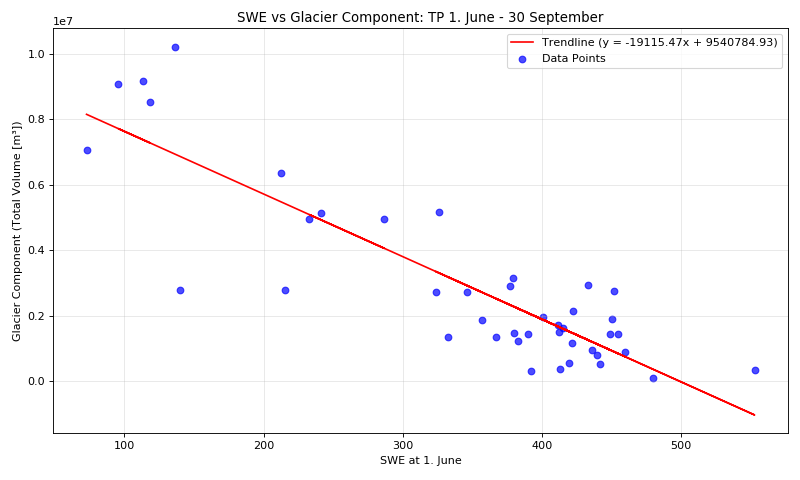

In [888]:

x = predictor_subset_df.squeeze()  # Predictor data
y = glacier_component.sel(target_period=test_target_period)['total_volume_m3'].values  # Glacier component data

#Calculate Trendline
coefficients = np.polyfit(x, y, 1)  # Fit a 1st-degree polynomial (linear)
slope, intercept = coefficients
trendline = slope * x + intercept  # Compute trendline values

# Step 5: Plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(x, y, color='blue', label='Data Points', alpha=0.7)

# Trendline
plt.plot(x, trendline, color='red', label=f'Trendline (y = {slope:.2f}x + {intercept:.2f})')

# Add Labels and Title
plt.xlabel("SWE at 1. June")
plt.ylabel("Glacier Component (Total Volume [m³])")
plt.title("SWE vs Glacier Component: TP 1. June - 30 September")
plt.legend()

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


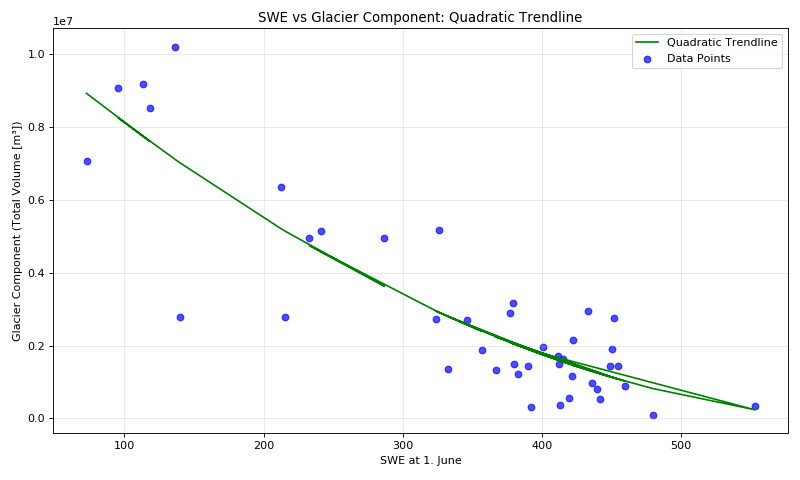

In [897]:
# Calculate a second-degree polynomial trendline
coefficients = np.polyfit(x, y, 2)  # Fit a 2nd-degree polynomial
quadratic_trendline = coefficients[0] * x**2 + coefficients[1] * x + coefficients[2]  # Compute quadratic trendline values

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(x, y, color='blue', label='Data Points', alpha=0.7)

# Quadratic Trendline
plt.plot(x, quadratic_trendline, color='green', label=f'Quadratic Trendline')

# Add Labels and Title
plt.xlabel("SWE at 1. June")
plt.ylabel("Glacier Component (Total Volume [m³])")
plt.title("SWE vs Glacier Component: Quadratic Trendline")
plt.legend()

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [889]:
years = x.index.year

# Erstelle einen neuen DataFrame
SWE_and_GL = pd.DataFrame({
    'Year': years,
    'SWE': x.values,
    'Vol': y
})

# Setze 'Year' als Index
SWE_and_GL.set_index('Year', inplace=True)

# Zeige den neuen Datensatz an
display(SWE_and_GL.head())



,SWE,Vol
Year,,
1981,459.720784,8.858640e+05
1982,439.764596,7.957914e+05
1983,382.712102,1.214629e+06
1984,441.462579,5.264743e+05
1985,448.926928,1.432379e+06


In [890]:
# Split the timeseries into training and validation timeseries for forecasting
train_data_dict_1, test_data_dict_1 = leave_out(SWE_and_GL, nyears_leaveout_default)

# Loop over the samples
for s in list(train_data_dict_1.keys()):

    # Select train and test data
    train_data_1 = train_data_dict_1[s]
    test_data_1 = test_data_dict_1[s]

    # Fit the model on the training data
    OLS_model_1 = OLS_model_fitting('SWE', train_data_1)

    # Perform out-of-sample deterministic forecasting for the testing period
    fc_det_1 = deterministic_forecasting(OLS_model_1, test_data_1)

    # Calculate errors standard deviation for the training period
    fc_det_train_1 = deterministic_forecasting(OLS_model_1, train_data_1)
    rmse_1 = mean_squared_error(train_data_1['Vol'].values, fc_det_train_1['Vol_fc_mean'].values, squared=False)

    # generate ensembles
    fc_ens_1 = ensemble_dressing(fc_det_1, rmse_1, ens_size=ens_size_default)

    # append all ensembles generated for each moving window
    if s == 0:
        fc_ens_df_1 = fc_ens_1
    else:
        fc_ens_df_1 = pd.concat([fc_ens_df_1,fc_ens_1])


In [891]:
"""
# plot von oben code angepasst damit es funktioniert 
#Sortiere nach 'Vol_fc_mean' und stelle sicher, dass Indizes übereinstimmen
sorted_data_1 = fc_det_train_1.sort_values(by='Vol_fc_mean')

# Überprüfen der relevanten Daten (falls nötig, diese Zeilen auskommentieren)
print(train_data_1['SWE'].loc[sorted_data_1.index].head())
print(sorted_data_1['Vol_fc_mean'].head())

# Erstellen des Plots
plt.figure(figsize=(10, 6))

# Streudiagramm der Beobachtungen
plt.scatter(train_data_1['SWE'], train_data_1['Vol'], color='r', label='observations')

# Regressionslinie plotten
plt.plot(train_data_1['SWE'].loc[sorted_data_1.index], sorted_data_1['Vol_fc_mean'], color='b', label='regression line')

# Füllung für Standardabweichung der Fehler (rmse)
plt.fill_between(train_data_1['SWE'].loc[sorted_data_1.index], 
                 sorted_data_1['Vol_fc_mean'] + rmse_1, 
                 sorted_data_1['Vol_fc_mean'] - rmse_1, 
                 color='purple', alpha=.1, label='errors SD')

# Achsenbeschriftungen
plt.xlabel('Standardized SWE PC1')
plt.ylabel('Volume [m$^3$]')
plt.legend()

# Zeige den Plot an
plt.show()
"""

"\n# plot von oben code angepasst damit es funktioniert \n#Sortiere nach 'Vol_fc_mean' und stelle sicher, dass Indizes übereinstimmen\nsorted_data_1 = fc_det_train_1.sort_values(by='Vol_fc_mean')\n\n# Überprüfen der relevanten Daten (falls nötig, diese Zeilen auskommentieren)\nprint(train_data_1['SWE'].loc[sorted_data_1.index].head())\nprint(sorted_data_1['Vol_fc_mean'].head())\n\n# Erstellen des Plots\nplt.figure(figsize=(10, 6))\n\n# Streudiagramm der Beobachtungen\nplt.scatter(train_data_1['SWE'], train_data_1['Vol'], color='r', label='observations')\n\n# Regressionslinie plotten\nplt.plot(train_data_1['SWE'].loc[sorted_data_1.index], sorted_data_1['Vol_fc_mean'], color='b', label='regression line')\n\n# Füllung für Standardabweichung der Fehler (rmse)\nplt.fill_between(train_data_1['SWE'].loc[sorted_data_1.index], \n                 sorted_data_1['Vol_fc_mean'] + rmse_1, \n                 sorted_data_1['Vol_fc_mean'] - rmse_1, \n                 color='purple', alpha=.1, label='er

<IPython.core.display.Javascript object>


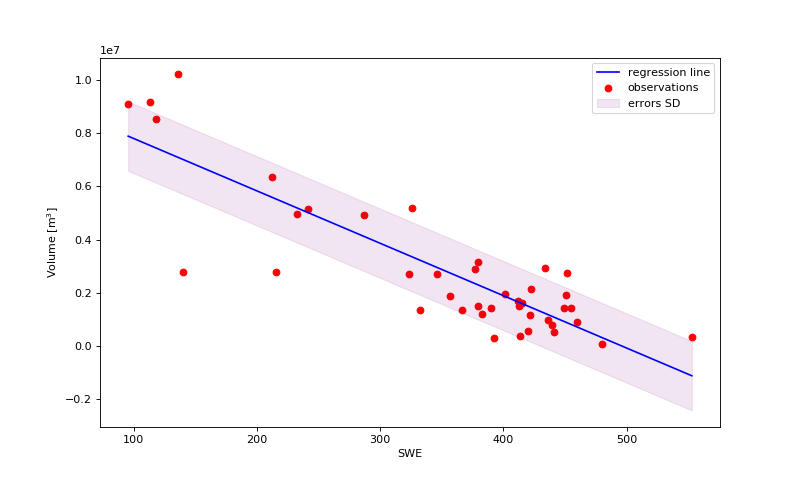

In [892]:
# Sortiere die SWE-Werte direkt
sorted_SWE = train_data_1['SWE'].sort_values()

# Berechne die Vorhersagen für die sortierten SWE-Werte
regression_line = OLS_model_1.predict(pd.DataFrame({'SWE': sorted_SWE}))

# Erstelle den Plot
plt.figure(figsize=(10, 6))

# Streudiagramm der Beobachtungen
plt.scatter(train_data_1['SWE'], train_data_1['Vol'], color='r', label='observations')

# Zeichne die korrigierte Regressionslinie
plt.plot(sorted_SWE, regression_line, color='b', label='regression line')

# Füllung für Standardabweichung der Fehler (rmse)
plt.fill_between(sorted_SWE, 
                 regression_line + rmse_1, 
                 regression_line - rmse_1, 
                 color='purple', alpha=0.1, label='errors SD')

# Achsenbeschriftungen
plt.xlabel('SWE')
plt.ylabel('Volume [m$^3$]')
plt.legend()

# Zeige den Plot
plt.show()


<IPython.core.display.Javascript object>


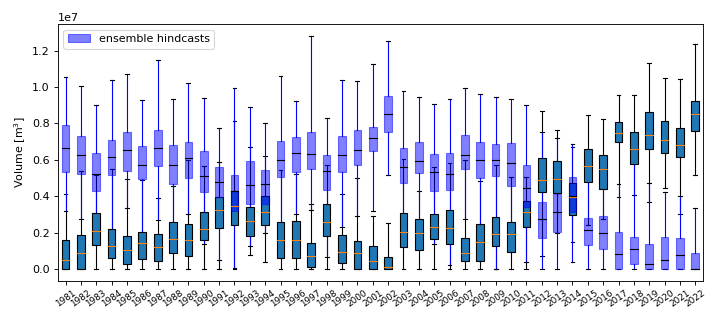

In [893]:
# Plot timeseries of ensemble hindcasts and observations
fig = plt.figure(figsize=(9,4))
ts_ax = plt.subplot()
#obs, = ts_ax.plot(np.arange(1, len(overlapping_predictand_data.index)+1), overlapping_predictand_data.values, color='red', label='observations', marker='o')
bp = plt.boxplot(np.transpose(fc_ens_df_1.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
bp = plt.boxplot(np.transpose(fc_ens_df.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
plt.setp(bp['boxes'], color='b', alpha=.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')
bluepatch = mpatches.Patch(color='b', alpha=.5, label='ensemble hindcasts')
ts_ax.set_ylabel('Volume [m$^3$]')
ts_ax.set_xticks(np.arange(1, len(overlapping_predictand_data.index)+1))
ts_ax.set_xticklabels(overlapping_predictand_data.index.values, rotation=35, fontsize=8)
plt.legend(handles=[bluepatch])
plt.tight_layout();

               1             2             3             4             5    \
Year                                                                         
1981  6.550934e+06  7.791422e+06  8.806126e+06  7.817143e+06  7.729604e+06   
1982  6.157132e+06  1.296930e+07  6.119203e+06  7.566312e+06  6.683816e+06   
1983  8.297167e+06  9.897501e+06  6.815599e+06  5.227785e+06  7.748003e+06   
1984  7.561382e+06  5.086351e+06  5.347812e+06  1.162733e+07  1.061838e+07   
1985  8.357859e+06  7.614968e+06  7.083529e+06  4.772019e+06  7.597004e+06   

               6             7             8             9             10   \
Year                                                                         
1981  8.553454e+06  7.368496e+06  8.434170e+06  8.048888e+06  5.289802e+06   
1982  4.553890e+06  6.201191e+06  7.711467e+06  9.572479e+06  9.131968e+06   
1983  9.788366e+06  5.491364e+06  6.335377e+06  5.762603e+06  5.794716e+06   
1984  7.831673e+06  6.213751e+06  1.033099e+07  9.472099e+06  7

<IPython.core.display.Javascript object>


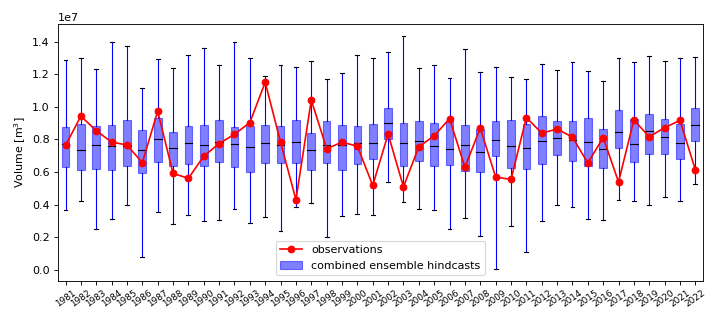

In [894]:
original_streamflow = xr.open_dataset(settings['output_data_path']+"Vol_1979_2021_basin_original"+test_basin_id+".nc")
original_streamflow = original_streamflow.sel(Station_ID=test_basin_id)
original_streamflow = original_streamflow.to_dataframe().reset_index().drop(columns=['lat','lon','Station_ID']).set_index('year')

original_streamflow = original_streamflow['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

# Sicherstellen, dass die Dimensionen übereinstimmen
if fc_ens_df_1.shape != fc_ens_df.shape:
    raise ValueError("Die Dimensionen von fc_ens_df_1 und fc_ens_df stimmen nicht überein!")

# Addiere die beiden DataFrames elementweise
fc_ens_combined = fc_ens_df_1 + fc_ens_df

# Optional: Überprüfen, ob die Kombination erfolgreich ist
print(fc_ens_combined.head())

# Erstellen des Boxplots für die kombinierten DataFrames
fig, ax = plt.subplots(figsize=(9, 4))

# Beobachtungsdaten plotten
obs, = ax.plot(
    np.arange(1, len(original_streamflow.index) + 1),
    original_streamflow.values,
    color='red',
    label='observations',
    marker='o'
)

# Boxplot für die kombinierten Daten
bp = ax.boxplot(
    np.transpose(fc_ens_combined.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False
)

# Stil für den Boxplot
plt.setp(bp['boxes'], color='b', alpha=0.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')

# Achsenbeschriftungen
ax.set_ylabel('Volume [m$^3$]')
ax.set_xticks(np.arange(1, len(original_streamflow.index) + 1))
ax.set_xticklabels(original_streamflow.index.values, rotation=35, fontsize=8)

# Legende
blue_patch = mpatches.Patch(color='b', alpha=0.5, label='combined ensemble hindcasts')
ax.legend(handles=[obs, blue_patch])

# Zeige den Plot
plt.tight_layout()
plt.show()


In [895]:
from scipy.stats import pearsonr

# Step 1: Extract observations
observations = original_streamflow.values

# Step 2: Calculate mean or median of ensemble hindcasts
simulations = fc_ens_combined.mean(axis=1).values  # Use .median(axis=1).values for the median

# Step 3: Calculate KGE components
r, _ = pearsonr(simulations, observations)  # Pearson correlation coefficient
beta = np.std(simulations) / np.std(observations)  # Variability ratio
gamma = np.mean(simulations) / np.mean(observations)  # Bias ratio

# Step 4: Calculate KGE
KGE = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

# Output the KGE value
print(f"Kling-Gupta Efficiency (KGE): {KGE:.4f}")


Kling-Gupta Efficiency (KGE): -0.3950


year
1981    7.629599e+06
1982    9.429137e+06
1983    8.536968e+06
1984    7.838905e+06
1985    7.657860e+06
Name: Vol_1Sep-30Sep, dtype: float64

<IPython.core.display.Javascript object>


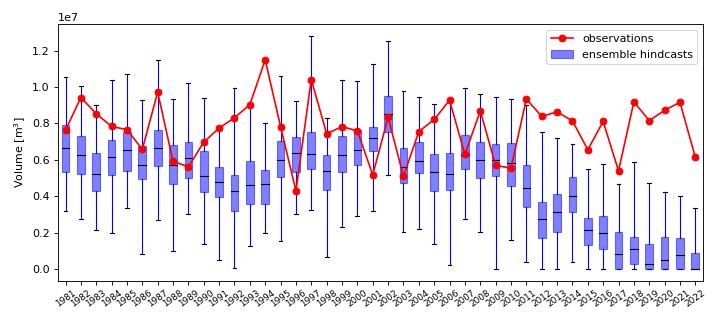

In [896]:
# comparison original modeled (prevah) and FROSTBYTE hindcast without glacier component
# calculate modeled streamflow volumes
# Plot timeseries of ensemble hindcasts and observations
original_streamflow = xr.open_dataset(settings['output_data_path']+"Vol_1979_2021_basin_original"+test_basin_id+".nc")
original_streamflow = original_streamflow.sel(Station_ID=test_basin_id)
original_streamflow = original_streamflow.to_dataframe().reset_index().drop(columns=['lat','lon','Station_ID']).set_index('year')

original_streamflow = original_streamflow['Vol_'+str(target_start_day)+target_start_month_name+'-'+str(target_end_day)+target_end_month_name]

display(original_streamflow.head())

fig = plt.figure(figsize=(9,4))
ts_ax = plt.subplot()
obs, = ts_ax.plot(np.arange(1, len(original_streamflow.index)+1), original_streamflow.values, color='red', label='observations', marker='o')
bp = plt.boxplot(np.transpose(fc_ens_df.values), patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
plt.setp(bp['boxes'], color='b', alpha=.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')
bluepatch = mpatches.Patch(color='b', alpha=.5, label='ensemble hindcasts')
ts_ax.set_ylabel('Volume [m$^3$]')
ts_ax.set_xticks(np.arange(1, len(overlapping_predictand_data.index)+1))
ts_ax.set_xticklabels(overlapping_predictand_data.index.values, rotation=35, fontsize=8)
plt.legend(handles=[obs,bluepatch])
plt.tight_layout();